You should me more organized. You are still learning though

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [3]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

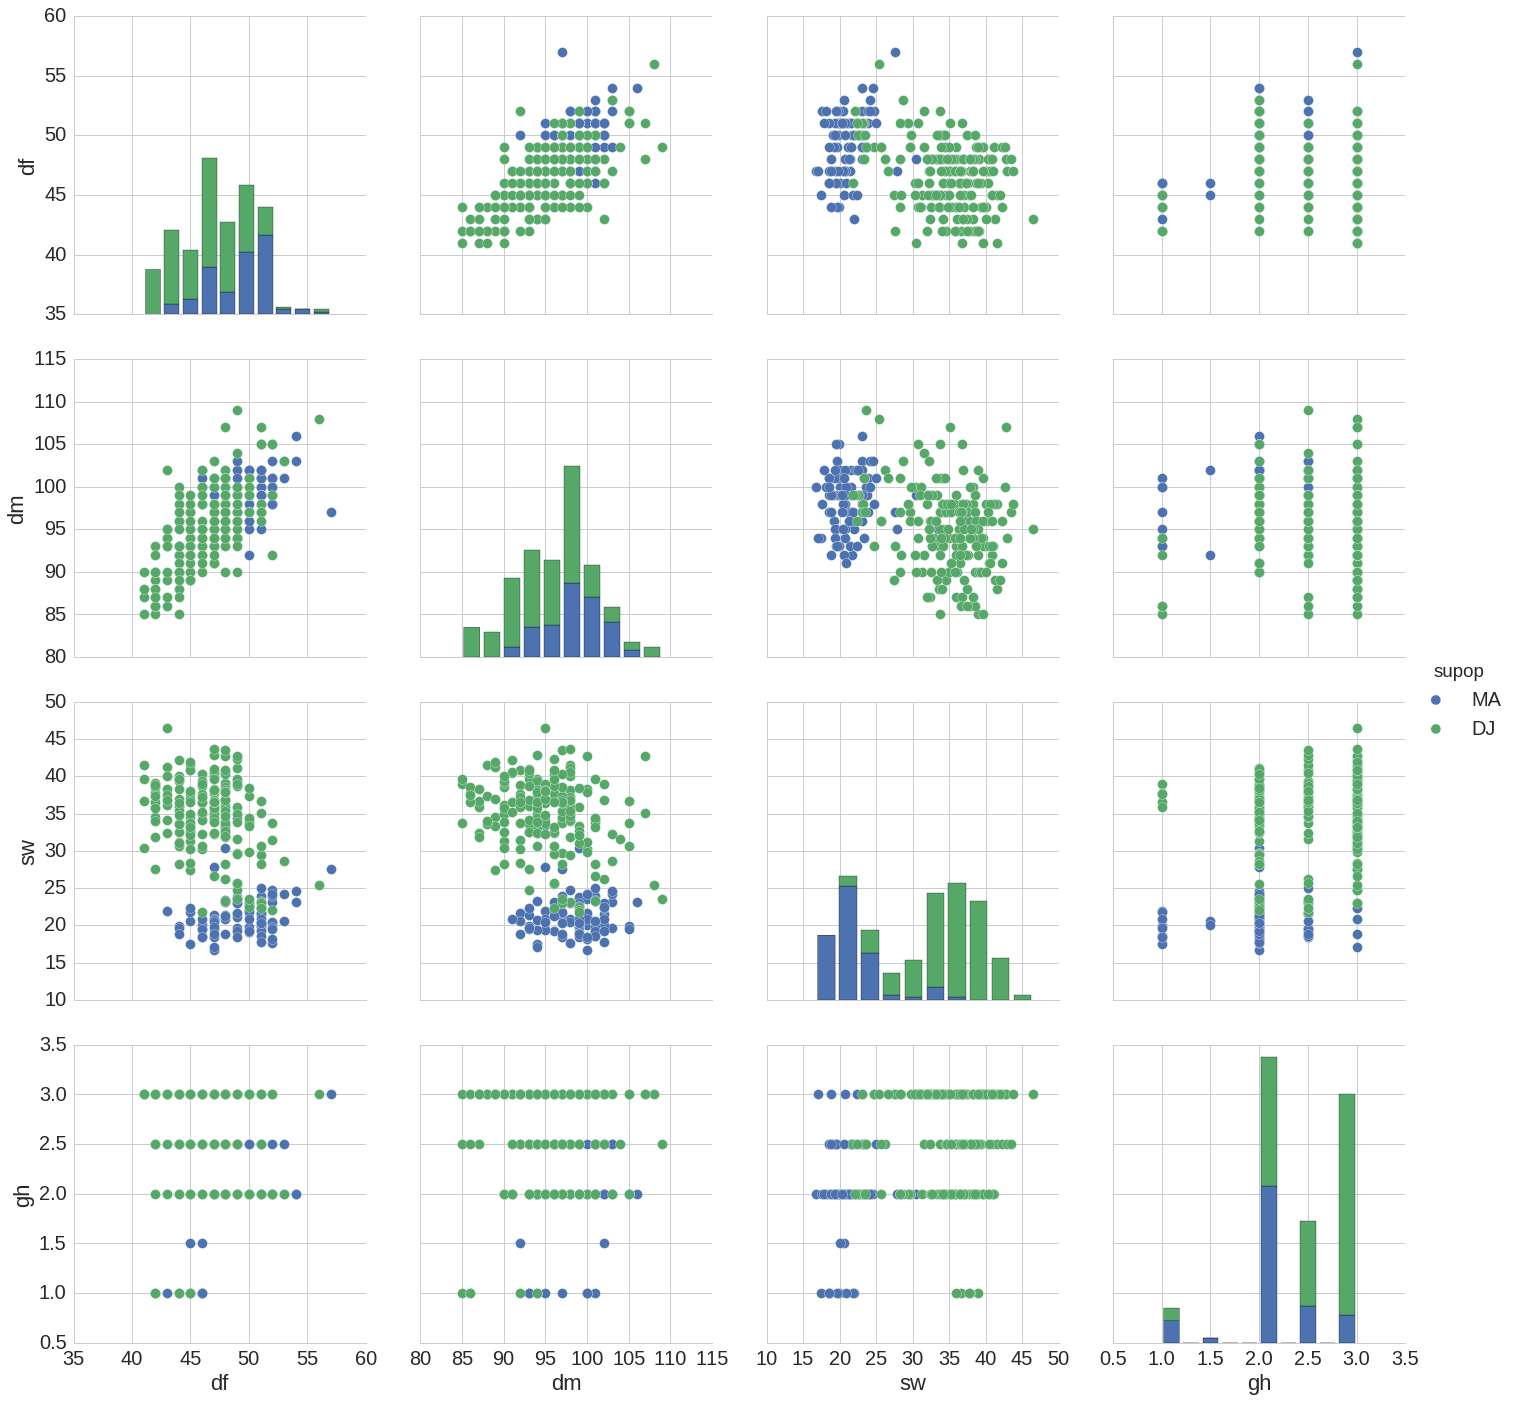

In [4]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [5]:
# import custom module
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split

## Stratify byclass

## Early 25%

In [6]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

classification_prescreen_early = classification_task_score(X_train, y_train, 
                                                     strat=y_train, scorer='recall_macro',
                                                           cv = 5, jobs=7)

Processing RandomForest model 1 of 9
Processing KNeighbors model 2 of 9
Processing MLP model 3 of 9
Processing SVC model 4 of 9
Processing LogisticRegression model 5 of 9
Processing linearSVC model 6 of 9
Processing SGD model 7 of 9
Processing GradientBoosting model 8 of 9
Processing Bagging model 9 of 9


## Late 25

In [7]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

classification_prescreen_late = classification_task_score(X_train, y_train, 
                                                     strat=y_train, scorer='recall_macro',
                                                          cv = 5, jobs=7)

Processing RandomForest model 1 of 9
Processing KNeighbors model 2 of 9
Processing MLP model 3 of 9
Processing SVC model 4 of 9
Processing LogisticRegression model 5 of 9
Processing linearSVC model 6 of 9
Processing SGD model 7 of 9
Processing GradientBoosting model 8 of 9
Processing Bagging model 9 of 9


## 3 classes

In [8]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

classification_prescreen_all = classification_task_score(X_train, y_train, 
                                                     strat=y_train, scorer='recall_macro',
                                                         cv = 5, jobs=7)

Processing RandomForest model 1 of 9
Processing KNeighbors model 2 of 9
Processing MLP model 3 of 9
Processing SVC model 4 of 9
Processing LogisticRegression model 5 of 9
Processing linearSVC model 6 of 9
Processing SGD model 7 of 9
Processing GradientBoosting model 8 of 9
Processing Bagging model 9 of 9


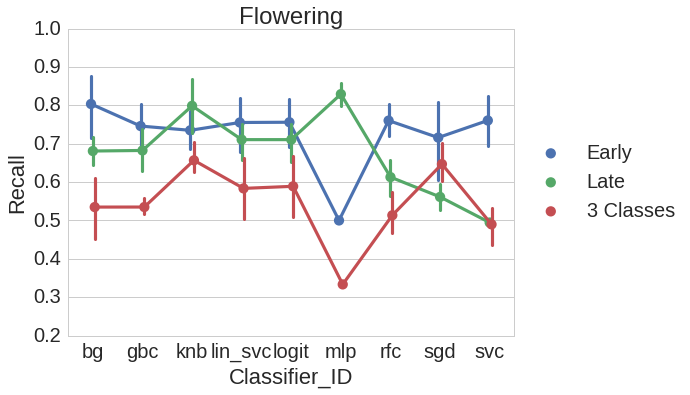

In [9]:
# plot both
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
two_class = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])

sns.pointplot(x='Classifier_ID', y='Score', hue='Class',
                   data = two_class, dodge=True)
plt.ylabel('Recall')
plt.title('Flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

It seems that the best performance is achieved for binary classes (maybe KNB/Logit/SGD can be used for 3 classes).

I will start with two classes and the following algorithms using **recall_macro**:

1. KNB

2. Logit

3. GBC

You should try to select similar models between early and late, and do a majority classifier

You should maybe try a GriSearch with the most mimportant parameters only?

# Prepare data-Early25%

Prepare data

In [6]:
from sklearn.metrics import precision_score, f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)
y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(recall_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)
    

## KNB

In [13]:
from sklearn.neighbors import KNeighborsClassifier

kn_default = KNeighborsClassifier()
y_pred = report_res(kn_default, X_train, y_train, 'macro')

0.736160892075
             precision    recall  f1-score   support

          0       0.59      0.65      0.62        62
          1       0.86      0.83      0.84       162

avg / total       0.78      0.78      0.78       224



0.791417761848
             precision    recall  f1-score   support

          0       0.61      0.77      0.68        62
          1       0.90      0.81      0.85       162

avg / total       0.82      0.80      0.81       224



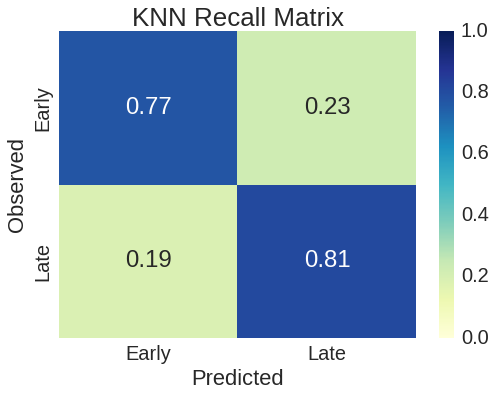

In [19]:
kn_optimal = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                                  metric_params=None, n_jobs=6, n_neighbors=22, p=2,
                                  weights='distance')

kn_optimal.fit(X_train, y_train)
y_pred = cross_val_predict(kn_optimal, X_train, y_train,
                          groups=y_train, cv = 5, n_jobs=6)
conf_matrix = confusion_matrix(y_train, y_pred)
print(recall_score(y_train, y_pred, average='macro'))
print(classification_report(y_train, y_pred))

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('KNN Recall Matrix', fontsize=26)
plt.show()

## Logit 

In [17]:
from sklearn.linear_model import LogisticRegression

lg_default = LogisticRegression(random_state=42)
y_pred = report_res(lg_default, X_train, y_train, 'macro')

0.755874153724
             precision    recall  f1-score   support

          0       0.67      0.63      0.65        62
          1       0.86      0.88      0.87       162

avg / total       0.81      0.81      0.81       224



In [20]:
param_grid = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 6, 10),
             'solver':['liblinear', 'saga'], 'class_weight': [None, 'balanced']}

lg = LogisticRegression(random_state=42, n_jobs=6)

#lg_search_param = GridSearchCV(lg,param_grid=param_grid,
                                   # scoring='recall_macro',n_jobs=6,iid=False,
                                    # cv=5)
#lg_search_param.fit(X_train, y_train)
##print(lg_search_param.best_params_)
#print(lg_search_param.best_estimator_)
lg_best = LogisticRegression(C=0.016681005372000592, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=6, penalty='l1',
          random_state=42, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

#y_pred=report_res(lg_search_param, X_train, y_train, 'macro')


Older grid search: 

param_grid = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 6, 10),
             'solver':['liblinear', 'saga'], 'class_weight': [None, 'balanced']}

{'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.016681005372000592}
LogisticRegression(C=0.016681005372000592, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=6, penalty='l1',
          random_state=42, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)
0.787634408602
             precision    recall  f1-score   support

          0       0.63      0.74      0.68        62
          1       0.89      0.83      0.86       162

avg / total       0.82      0.81      0.81       224


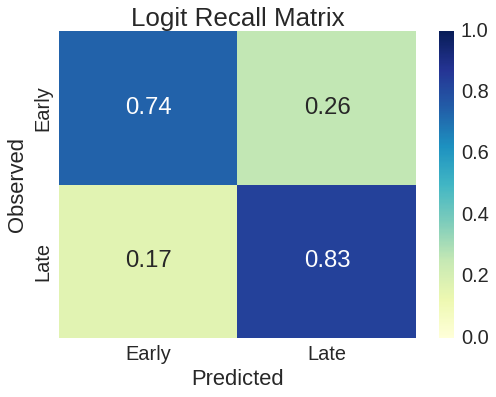

In [22]:
conf_matrix = confusion_matrix(y_train, y_pred)

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Logit Recall Matrix', fontsize=26)
plt.show()

## GBC

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
gb_default = GradientBoostingClassifier(random_state=42)
y_pred = report_res(gb_default, X_train, y_train, 'macro')

0.715551573078
             precision    recall  f1-score   support

          0       0.64      0.55      0.59        62
          1       0.84      0.88      0.86       162

avg / total       0.78      0.79      0.78       224



In [13]:
# you should first optimize the number of estimators with a grid search.
# accordinggly to this ling :
#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# it is better to first train the number of estimators first
# If N_estimator ~20 you should lower learning rate, if ~100 increase that
# otherwise the default of 0.1 works pretty fine
gb = GradientBoostingClassifier(learning_rate=0.08, random_state=42)

param_grid_1 = {'n_estimators':np.linspace(20, 120, 10, dtype=int)}
#             'max_depth': [4,6,8,10], 'subsample':np.linspace(0.5,1, 5),
#             'min_samples_leaf':[0.1, 0.2, 0.3, 0.4],
#             'learning_rate' :np.logspace(-4, 1, 5)}

gb_search_param_1 = GridSearchCV(gb,param_grid=param_grid_1,
                                    scoring='recall_macro',n_jobs=6,iid=False,
                                     cv=5)

# check how that works!
gb_search_param_1.fit(X_train, y_train)
print(gb_search_param_1.best_params_)
print(gb_search_param_1.best_estimator_)
y_pred=report_res(gb_search_param_1, X_train, y_train, 'macro')

{'n_estimators': 42}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=42,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
0.709378733572
             precision    recall  f1-score   support

          0       0.62      0.55      0.58        62
          1       0.83      0.87      0.85       162

avg / total       0.77      0.78      0.78       224



In [ ]:
{'n_estimators': 31}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=31,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
0.728594185583
             precision    recall  f1-score   support

          0       0.64      0.58      0.61        62
          1       0.85      0.88      0.86       162

avg / total       0.79      0.79      0.79       224



In [11]:
gb_search_param_1.best_params_['n_estimators']

31

{'subsample': 1.0, 'max_depth': 4, 'min_samples_leaf': 0.2}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=31,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
0.711270410195
             precision    recall  f1-score   support

          0       0.60      0.56      0.58        62
          1       0.84      0.86      0.85       162

avg / total       0.77      0.78      0.77       224



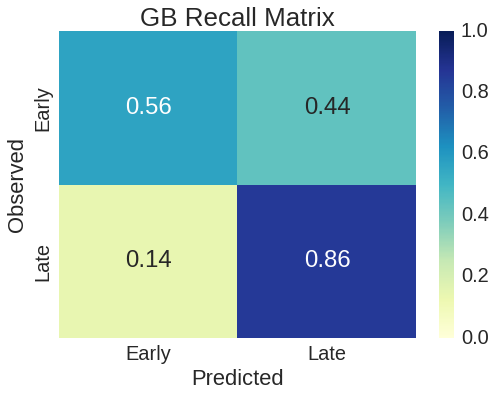

In [15]:
# second round of estimates
# default learning rate
estimators = 31#gb_search_param_1.best_params_['n_estimators']
gb2 = GradientBoostingClassifier(n_estimators=estimators, random_state=42)

param_grid_2 =  {'max_depth': [4,6,8,10], 'subsample':np.linspace(0.5,1, 5),
                 'min_samples_leaf':[0.1, 0.2, 0.3, 0.4]}

gb_search_param =  GridSearchCV(gb2,param_grid=param_grid_2,
                                    scoring='recall_macro',n_jobs=6,iid=False,
                                     cv=5)

gb_search_param.fit(X_train, y_train)
print(gb_search_param.best_params_)
print(gb_search_param.best_estimator_)
y_pred=report_res(gb_search_param, X_train, y_train, 'macro')

conf_matrix = confusion_matrix(y_train, y_pred)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('GB Recall Matrix', fontsize=26)
plt.show()

# Early Report best models

In [ ]:
kn_optimal = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                                  metric_params=None, n_jobs=6, n_neighbors=22, p=2,
                                  weights='distance')

logit_optimal = LogisticRegression(C=0.016681005372000592, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=6, penalty='l1',
          random_state=42, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

gbc_optimal = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=31,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

# Late

Use same model by test with the others param
## prepare data


In [ ]:
from sklearn.metrics import precision_score, f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)
y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(recall_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)
    

## KNB

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn_default = KNeighborsClassifier()
y_pred = report_res(kn_default, X_train, y_train, 'macro')

param_grid = {'n_neighbors': np.linspace(1,50, 10, dtype=int),
             'weights': ['uniform', 'deistance'],
             'metric':['euclidean', 'manhattan', 'minkowski']}

kn = KNeighborsClassifier()

kn_search=GridSearchCV(kn, param_grid=param_grid,
                      scoring='recall_macro', n_jobs=6, iid=False,
                      cv=5)

kn_search.fit(X_train, y_train)
y_pred = cross_val_predict(kn_optimal, X_train, y_train,
                          groups=y_train, cv = 5, n_jobs=6)
conf_matrix = confusion_matrix(y_train, y_pred)
print(recall_score(y_train, y_pred, average='macro'))
print(classification_report(y_train, y_pred))

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('KNN Recall Matrix', fontsize=26)
plt.show()

## LOGIT

In [ ]:
from sklearn.linear_model import LogisticRegression

lg_default = LogisticRegression(random_state=42)
y_pred = report_res(lg_default, X_train, y_train, 'macro')

param_grid = {'penalty':['l1', 'l2'], 'C':np.logspace(-4, 6, 10),
             'solver':['liblinear', 'saga'], 'class_weight': [None, 'balanced']}

lg = LogisticRegression(random_state=42, n_jobs=6)

lg_search_param = GridSearchCV(lg,param_grid=param_grid,
                               scoring='recall_macro',n_jobs=6,iid=False,
                               cv=5)
lg_search_param.fit(X_train, y_train)
print(lg_search_param.best_params_)
print(lg_search_param.best_estimator_)
y_pred=report_res(lg_search_param, X_train, y_train, 'macro')


## GBC

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_default = GradientBoostingClassifier(random_state=42)
y_pred = report_res(gb_default, X_train, y_train, 'macro')

gb = GradientBoostingClassifier(random_state=42)
param_grid_1 = {'n_estimators':np.linspace(20, 120, 10, dtype=int)}

gb_search_param_1 = GridSearchCV(gb,param_grid=param_grid_1,
                                    scoring='recall_macro',n_jobs=6,iid=False,
                                     cv=5)

# check how that works!
gb_search_param_1.fit(X_train, y_train)
print(gb_search_param_1.best_params_)
print(gb_search_param_1.best_estimator_)
y_pred=report_res(gb_search_param_1, X_train, y_train, 'macro')

In [ ]:
estimators = gb_search_param_1.best_params_['n_estimators']
gb2 = GradientBoostingClassifier(n_estimators=estimators, random_state=42)

param_grid_2 =  {'max_depth': [4,6,8,10], 'subsample':np.linspace(0.5,1, 5),
                 'min_samples_leaf':[0.1, 0.2, 0.3, 0.4]}

gb_search_param =  GridSearchCV(gb2,param_grid=param_grid_2,
                                    scoring='recall_macro',n_jobs=6,iid=False,
                                     cv=5)

gb_search_param.fit(X_train, y_train)
print(gb_search_param.best_params_)
print(gb_search_param.best_estimator_)
y_pred=report_res(gb_search_param, X_train, y_train, 'macro')

conf_matrix = confusion_matrix(y_train, y_pred)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Late'],
           yticklabels = ['Early', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('GB Recall Matrix', fontsize=26)
plt.show()